![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/track-and-monitor-experiments/logging-api/logging-api.png)

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Logging

_**This notebook showcases various ways to use the Azure Machine Learning service run logging APIs, and view the results in the Azure portal.**_

---
---

## Table of Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
    1. Validate Azure ML SDK installation
    1. Initialize workspace
    1. Set experiment
1. [Logging](#Logging)
    1. Starting a run
        1. Viewing a run in the portal
        1. Viewing the experiment in the portal
    1. Logging metrics
        1. Logging string metrics
        1. Logging numeric metrics
        1. Logging vectors
        1. Logging tables
        1. Uploading files
1. [Analyzing results](#Analyzing-results)
    1. Tagging a run
1. [Next steps](#Next-steps)


## Introduction

Logging metrics from runs in your experiments allows you to track results from one run to another, determining trends in your outputs and understand how your inputs correspond to your model and script performance.  Azure Machine Learning services (AzureML) allows you to track various types of metrics including images and arbitrary files in order to understand, analyze, and audit your experimental progress. 

Typically you should log all parameters for your experiment and all numerical and string outputs of your experiment.  This will allow you to analyze the performance of your experiments across multiple runs, correlate inputs to outputs, and filter runs based on interesting criteria.

The experiment's Run History report page automatically creates a report that can be customized to show the KPI's, charts, and column sets that are interesting to you. 

| ![Run Details](./img/run_details.PNG) | ![Run History](./img/run_history.PNG) |
|:--:|:--:|
| *Run Details* | *Run History* |

---

## Setup

If you are using an Azure Machine Learning Notebook VM, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb) Notebook first if you haven't already to establish your connection to the AzureML Workspace. Also make sure you have tqdm and matplotlib installed in the current kernel.

```
(myenv) $ conda install -y tqdm matplotlib
```

### Validate Azure ML SDK installation and get version number for debugging purposes

In [1]:
from azureml.core import Experiment, Workspace, Run
import azureml.core
import numpy as np
from tqdm import tqdm

# Check core SDK version number

print("This notebook was created using SDK version 1.39.0, you are currently running version", azureml.core.VERSION)

This notebook was created using SDK version 1.39.0, you are currently running version 1.39.0


### Initialize workspace

Initialize a workspace object from persisted configuration.

In [2]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: mlw-dev-geog-01
Azure region: eastus
Subscription id: 062bbb35-45d7-40c6-937f-a43ab3667b0f
Resource group: rg-dev-geog-eastus


### Set experiment
Create a new experiment (or get the one with the specified name).  An *experiment* is a container for an arbitrary set of *runs*. 

In [3]:
experiment = Experiment(workspace=ws, name='logging-api-test')

---

## Logging
In this section we will explore the various logging mechanisms.

### Starting a run

A *run* is a singular experimental trial.  In this notebook we will create a run directly on the experiment  by calling `run = exp.start_logging()`.  If you were experimenting by submitting a script file as an experiment using ``experiment.submit()``, you would call `run = Run.get_context()` in your script to access the run context of your code.  In either case, the logging methods on the returned run object work the same.

This cell also stores the run id for use later in this notebook.  The run_id is not necessary for logging.

In [4]:
# start logging for the run
run = experiment.start_logging()

# access the run id for use later
run_id = run.id

# change the scale factor on different runs to see how you can compare multiple runs
scale_factor = 2

# change the category on different runs to see how to organize data in reports
category = 'Red'

#### Viewing a run in the Portal
Once a run is started you can see the run in the portal by simply typing ``run``.  Clicking on the "Link to Portal" link will take you to the Run Details page that shows the metrics you have logged and other run properties.  You can refresh this page after each logging statement to see the updated results.

In [5]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
logging-api-test,2dc7a588-bc29-4320-9e4c-3c7dfbe55c9e,,Running,Link to Azure Machine Learning studio,Link to Documentation


### Viewing an experiment in the portal
You can also view an experiement similarly by typing `experiment`.  The portal link will take you to the experiment's Run History page that shows all runs and allows you to analyze trends across multiple runs.

In [6]:
experiment

Name,Workspace,Report Page,Docs Page
logging-api-test,mlw-dev-geog-01,Link to Azure Machine Learning studio,Link to Documentation


## Logging metrics
Metrics are visible in the run details page in the AzureML portal and also can be analyzed in experiment reports.  The run details page looks as below and contains tabs for Details, Outputs, Logs, and Snapshot.  
* The Details page displays attributes about the run, plus logged metrics and images.  Metrics that are vectors appear as charts.  
* The Outputs page contains any files, such as models, you uploaded into the "outputs" directory from your run into storage.  If you place files in the "outputs" directory locally, the files are automatically uploaded on your behald when the run is completed.
* The Logs page allows you to view any log files created by your run.  Logging runs created in notebooks typically do not generate log files.
* The Snapshot page contains a snapshot of the directory specified in the ''start_logging'' statement, plus the notebook at the time of the ''start_logging'' call.  This snapshot and notebook can be downloaded from the Run Details page to continue or reproduce an experiment.

### Logging string metrics
The following cell logs a string metric.  A string metric is simply a string value associated with a name.  A string metric String metrics are useful for labelling runs and to organize your data.  Typically you should log all string parameters as metrics for later analysis - even information such as paths can help to understand how individual experiements perform differently.

String metrics can be used in the following ways:
* Plot in hitograms
* Group by indicators for numerical plots
* Filtering runs

String metrics appear in the **Tracked Metrics** section of the Run Details page and can be added as a column in Run History reports.

In [7]:
# log a string metric
run.log(name='Category', value=category)

### Logging numerical metrics
The following cell logs some numerical metrics.  Numerical metrics can include metrics such as AUC or MSE.  You should log any parameter or significant output measure in order to understand trends across multiple experiments.  Numerical metrics appear in the **Tracked Metrics** section of the Run Details page, and can be used in charts or KPI's in experiment Run History reports.

In [8]:
# log numerical values
run.log(name="scale factor", value = scale_factor)
run.log(name='Magic Number', value=42 * scale_factor)

### Logging vectors
Vectors are good for recording information such as loss curves. You can log a vector by creating a list of numbers, calling ``log_list()`` and supplying a name and the list, or by repeatedly logging a value using the same name.

Vectors are presented in Run Details as a chart, and are directly comparable in experiment reports when placed in a chart. 

**Note:** vectors logged into the run are expected to be relatively small. Logging very large vectors into Azure ML can result in reduced performance. If you need to store large amounts of data associated with the run, you can write the data to file that will be uploaded.

In [9]:
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run.log_list(name='Fibonacci', value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run.log(name='Sigmoid', value=1 / (1 + np.exp(-i)))
    

100%|██████████| 20/20 [00:00<00:00, 10361.42it/s]


### Logging tables
Tables are good for recording related sets of information such as accuracy tables, confusion matrices, etc.  
You can log a table in two ways:
* Create a dictionary of lists where each list represents a column in the table and call ``log_table()``
* Repeatedly call ``log_row()`` providing the same table name with a consistent set of named args as the column values

Tables are presented in Run Details as a chart using the first two columns of the table  

**Note:** tables logged into the run are expected to be relatively small.  Logging very large tables into Azure ML can result in reduced performance.  If you need to store large amounts of data associated with the run, you can write the data to file that will be uploaded.

In [10]:
# create a dictionary to hold a table of values
sines = {}
sines['angle'] = []
sines['sine'] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * scale_factor
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run.log_row(name='Cosine Wave', angle=angle, cos=np.cos(angle))
        
    sines['angle'].append(angle)
    sines['sine'].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run.log_table(name='Sine Wave', value=sines)

100%|██████████| 20/20 [00:00<00:00, 10363.98it/s]


### Logging images
You can directly log _matplotlib_ plots and arbitrary images to your run record.  This code logs a _matplotlib_ pyplot object.  Images show up in the run details page in the Azure ML Portal.

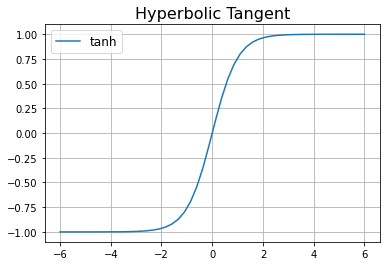

In [11]:
%matplotlib inline

# Create a plot
import matplotlib.pyplot as plt
angle = np.linspace(-3, 3, 50) * scale_factor
plt.plot(angle,np.tanh(angle), label='tanh')
plt.legend(fontsize=12)
plt.title('Hyperbolic Tangent', fontsize=16)
plt.grid(True)

# Log the plot to the run.  To log an arbitrary image, use the form run.log_image(name, path='./image_path.png')
run.log_image(name='Hyperbolic Tangent', plot=plt)

### Uploading files

Files can also be uploaded explicitly and stored as artifacts along with the run record. These files are also visible in the *Outputs* tab of the Run Details page.


In [12]:
import os
directory = 'logging-api'

if not os.path.exists(directory):
    os.mkdir(directory)

file_name = os.path.join(directory, "myfile.txt")

with open(file_name, "w") as f:
    f.write('This is an output file that will be uploaded.\n')

# Upload the file explicitly into artifacts 
run.upload_file(name = file_name, path_or_stream = file_name)

### Completing the run

Calling `run.complete()` marks the run as completed and triggers the output file collection.  If for any reason you need to indicate the run failed or simply need to cancel the run you can call `run.fail()` or `run.cancel()`.

In [13]:
run.complete()

---

## Analyzing results

You can refresh the run in the Azure portal to see all of your results.  In many cases you will want to analyze runs that were performed previously to inspect the contents or compare results.  Runs can be fetched from their parent Experiment object using the ``Run()`` constructor or the ``experiment.get_runs()`` method. 

In [14]:
fetched_run = Run(experiment, run_id)
fetched_run

Experiment,Id,Type,Status,Details Page,Docs Page
logging-api-test,2dc7a588-bc29-4320-9e4c-3c7dfbe55c9e,,Completed,Link to Azure Machine Learning studio,Link to Documentation


Call ``run.get_metrics()`` to retrieve all the metrics from a run.

In [15]:
fetched_run.get_metrics()

{'Category': 'Red',
 'scale factor': 2,
 'Magic Number': 84,
 'Fibonacci': [0, 2, 2, 4, 6, 10, 16, 26, 42, 68, 110, 178],
 'Sigmoid': [4.5397868702434395e-05,
  0.00012339457598623172,
  0.0003353501304664781,
  0.0009110511944006454,
  0.0024726231566347743,
  0.0066928509242848554,
  0.01798620996209156,
  0.04742587317756678,
  0.11920292202211755,
  0.2689414213699951,
  0.5,
  0.7310585786300049,
  0.8807970779778823,
  0.9525741268224334,
  0.9820137900379085,
  0.9933071490757153,
  0.9975273768433653,
  0.9990889488055994,
  0.9996646498695336,
  0.9998766054240137],
 'Cosine Wave': {'angle': [-10.0,
   -9.0,
   -8.0,
   -7.0,
   -6.0,
   -5.0,
   -4.0,
   -3.0,
   -2.0,
   -1.0,
   0.0,
   1.0,
   2.0,
   3.0,
   4.0,
   5.0,
   6.0,
   7.0,
   8.0,
   9.0],
  'cos': [-0.8390715290764524,
   -0.9111302618846769,
   -0.14550003380861354,
   0.7539022543433046,
   0.960170286650366,
   0.28366218546322625,
   -0.6536436208636119,
   -0.9899924966004454,
   -0.4161468365471424,
 

Call ``run.get_metrics(name = <metric name>)`` to retrieve a metric value by name. Retrieving a single metric can be faster, especially if the run contains many metrics.

In [16]:
fetched_run.get_metrics(name = "scale factor")

{'scale factor': 2}

See the files uploaded for this run by calling ``run.get_file_names()``

In [17]:
fetched_run.get_file_names()

['Hyperbolic Tangent_1649440539.png', 'logging-api/myfile.txt']

Once you know the file names in a run, you can download the files using the ``run.download_file()`` method

In [18]:
import os
os.makedirs('files', exist_ok=True)

for f in run.get_file_names():
    dest = os.path.join('files', f.split('/')[-1])
    print('Downloading file {} to {}...'.format(f, dest))
    fetched_run.download_file(f, dest)   

### Tagging a run
Often when you analyze the results of a run, you may need to tag that run with important personal or external information.  You can add a tag to a run using the ``run.tag()`` method.  AzureML supports valueless and valued tags.

In [ ]:
fetched_run.tag("My Favorite Run")
fetched_run.tag("Competition Rank", 1)

fetched_run.get_tags()

## Next steps
To experiment more with logging and to understand how metrics can be visualized, go back to the *Start a run* section, try changing the category and scale_factor values and going through the notebook several times.  Play with the KPI, charting, and column selection options on the experiment's Run History reports page to see how the various metrics can be combined and visualized.

After learning about all of the logging options, go to the [train on remote vm](..\train-on-remote-vm\train-on-remote-vm.ipynb) notebook and experiment with logging from remote compute contexts.